# 4. CNN + Augmentation



## Description


**Codabench accuracy** : 0.26

**Local test accuracy** : 0.96

**Description** : Basic CNN + GAP, Augmentation, Class Weighting Loss Function and Batch Normalization obtaining a small improvement on Codabench.

**Motivation** : Prove that they should improve generalization capability.



## Google Drive - Connecting to the project

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1"
%cd {project_path}
sys.path.append(project_path)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1


## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import utils

import numpy as np
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.utils.class_weight import compute_class_weight

## Parameters

In [ ]:
# We are dealing with an 8-class problem with 96x96 RGB images as input
OUTPUT_SIZE = 8
INPUT_SHAPE = (96,96,3)

## Load Data and Compute Weights

In [ ]:
# Loading Cleaned data and computing weights earlier, to better represent
# the classes distribution
X, y = utils.load_cleaned_dataset()
WEIGHTS = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
WEIGHTS = {i:WEIGHTS[i] for i in range(len(WEIGHTS))}
X_train, X_val, X_test, y_train, y_val, y_test = utils.split_dataset(X, y, test_size=0.2, val_size=0.2)

## Model Implementation

In [ ]:
#Parameter to define the probability of drop out of a neuron
DROPOUT_RATE = 0.4

In [ ]:
# Definition of the model
def build_model():
    # The input layer takse 96x96 RGB images
    input_layer = tfkl.Input(shape=INPUT_SHAPE, name='Input')

    # Normalization over the input data, to avoid preferred paths
    x = tfkl.BatchNormalization()(input_layer)

    # Augmentation layer providing random flip, translation, rotation and zoom
    augmentation = tfk.Sequential([
        tfkl.RandomFlip('horizontal_and_vertical'),
        tfkl.RandomRotation(0.2),
        tfkl.RandomTranslation(0.2, 0.2),
        tfkl.RandomContrast(0.3)
    ])

    x = augmentation(x)

    # Convolutional layers and max pooling layers with ReLU activation functions
    # and 3x3 kernel size, and a Batch Normalization in the middle.
    x = tfkl.Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_1')(input_layer)
    x = tfkl.MaxPooling2D(pool_size=(2,2), name='MaxPooling2D_1')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_2')(x)
    x = tfkl.MaxPooling2D(pool_size=(2,2), name='MaxPooling2D_2')(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_3')(x)
    x = tfkl.MaxPooling2D(pool_size=(2,2), name='MaxPooling2D_3')(x)

    # GAP layer to introduce translational invariance into the network and
    # reduce the number of parameters in FC layers
    x = tfkl.GlobalAveragePooling2D(name='GAP')(x)

    # Dense layer preceded by dropout for regularization
    x = tfkl.Dense(256, activation='relu', name='Dense_1')(x)
    x = tfkl.Dropout(DROPOUT_RATE, name='Dropout')(x)

    # Dense layer as output
    output_layer = tfkl.Dense(OUTPUT_SIZE, activation='softmax', name='Output')(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# Custom Learning Rate
LR = 5e-5

In [ ]:
# Model Construction
model = build_model()

# Model Compilation with Adam and sparse categorical crossentropy
model.compile(optimizer=tfk.optimizers.Adam(LR),
              loss=tfk.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Print model details
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_1 (MaxPooling2D)        │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_2 (MaxPooling2D)        │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_3 (MaxPooling2D)        │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GAP (GlobalAveragePooling2D)         │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,584 (502.28 KB)

 Trainable params: 128,456 (501.78 KB)

 Non-trainable params: 128 (512.00 B)

## Training

In [ ]:
# Training Parameters
EPOCHS = 1000
BATCH_SIZE = 64
PATIENCE = 20

In [ ]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)
callbacks = [early_stopping]

In [ ]:
# Actual training with the given parameters
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    class_weight=WEIGHTS,
                    validation_data=(X_val,y_val)).history

Epoch 1/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.2819 - loss: 1.9434 - val_accuracy: 0.1664 - val_loss: 2.0560
Epoch 2/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.4535 - loss: 1.4667 - val_accuracy: 0.1722 - val_loss: 1.9663
Epoch 3/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6022 - loss: 1.1583 - val_accuracy: 0.2337 - val_loss: 2.4215
Epoch 4/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6954 - loss: 0.9373 - val_accuracy: 0.3144 - val_loss: 2.0964
Epoch 5/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7520 - loss: 0.7671 - val_accuracy: 0.5765 - val_loss: 1.1436
Epoch 6/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7694 - loss: 0.6664 - val_accuracy: 0.5422 - val_loss: 1.1992
Epoch 7/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8017 - loss: 0.5926 - val_accuracy: 0.7947 - val_loss: 0.6625
Epoch 8/1000
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8284 - loss:

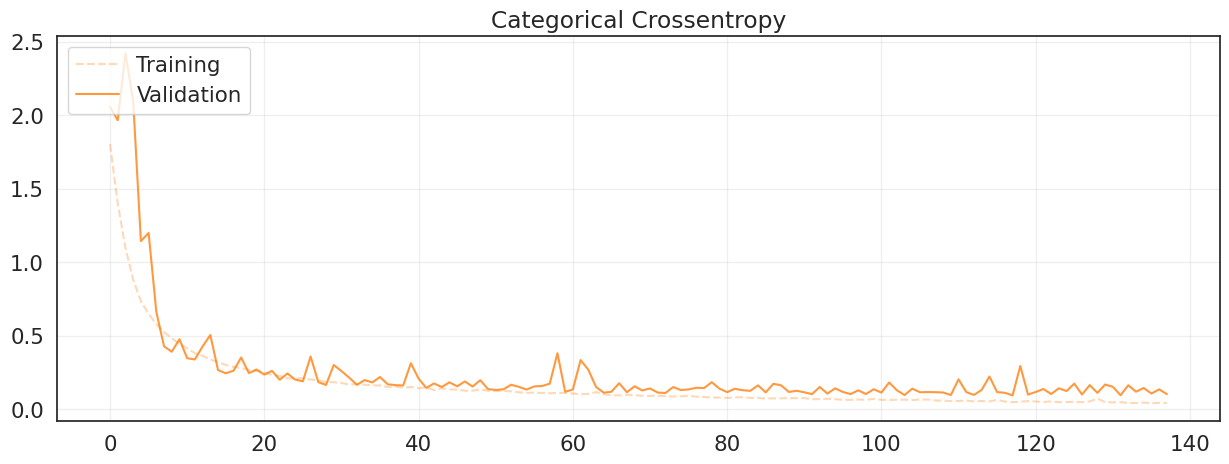

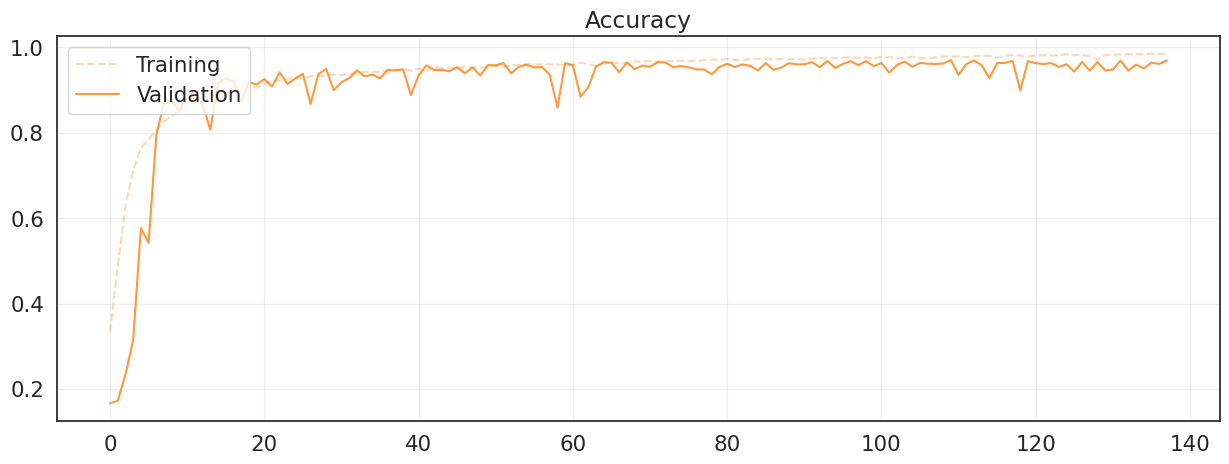

In [ ]:
# Plot the loss function and accuracy value over epochs
utils.plot_history(history)

## Save

In [ ]:
# Saving the model for testing and submission
accuracy = round(max(history['val_accuracy'])* 100, 2)
model_name = f"custom_cnn_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")


/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1/models
Saving custom_cnn_97.07.keras
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1
Model Saved


## Test Prediction and Final Evaluation

In [ ]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=1)

In [ ]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(y_test, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(y_test, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(y_test, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

Accuracy score over the test set: 0.9615
Precision score over the test set: 0.9616
Recall score over the test set: 0.9615
F1 score over the test set: 0.9614
